# Import

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import statistics
from scipy import signal, stats
import scipy.fftpack
from cycler import cycler

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
#%matplotlib notebook

# Reading files

In [3]:
common_folder = "/home/gorbunov8a/CODE/random_advection_test/e05/"
#common_folder = "/home/gorbunov8a/data/random_advection/dahu_test/"
#common_folder = "/home/gorbunov8a/data/random_advection/kareline_test/"

file_type = "time_series"
component = "scalar1"
series_type = "lin"

file = common_folder + file_type + "_" + component + "_" + series_type + ".table"
file_list = []
print(file)
for line in open(file) :
    temp_array_line = []
    try :
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            file_list.append(temp_array_line)
    except :
        print('error')
    
file_array = np.array(file_list[1:-1])
k = np.array(file_list[0])
time = file_array[:,0]
energy = file_array[:,1:]
#del temp_array_line, file_array, file_list

/home/gorbunov8a/CODE/random_advection_test/e05/time_series_scalar1_lin.table


In [4]:
time.shape

(1275,)

In [5]:
k.shape

(80,)

In [6]:
energy.shape

(1275, 80)

# Parameters

In [7]:
def find_D0(prefactor, nu, eps, Sc, N, keta) :
    return [prefactor*4.0*nu*eps/Sc*((2.0*keta/N)**(-eps)), np.pi*N/keta]

In [8]:
eps = 0.5
N = 128
nu = 1.0
Sc = 1000.0
keta = 4.0*np.pi
D0_prefactor = 500.0
scale_separation = 16.0

find_D0(D0_prefactor, nu, eps, Sc, N, keta)

[2.256758334191025, 32.0]

In [9]:
# Plotting options
plt.rc('axes', labelsize=14)  
plt.rc('axes', titlesize=14)  
plt.rc('legend', fontsize=12)  

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
default_cycler = cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors))
plt.rc('axes', prop_cycle=default_cycler)

In [10]:
kmin = 1
kmax = np.max(k)
nb_of_curves = 10
step = round((kmax - kmin)/nb_of_curves)
indices_of_k_to_plot = np.arange(kmin,kmax,step, dtype=np.int16)
print(indices_of_k_to_plot)

[ 1  9 17 25 33 41 49 57 65 73]


In [11]:
normalization_status = True
k_norm_coef = 1.0

# Plot time series

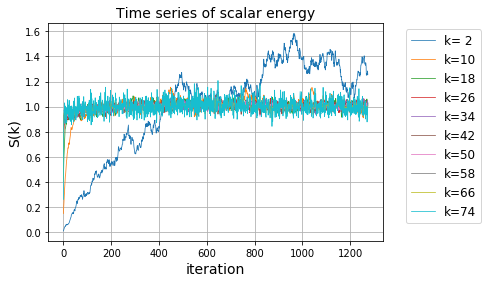

In [12]:
norm_coef = np.zeros_like(k, dtype=float)

for ik in indices_of_k_to_plot :
    if normalization_status :
        norm_coef[ik] = 1.0/np.mean(energy[:,ik])
    else : 
        norm_coef[ik] = 1.0
    plt.plot(np.real(energy[:,ik])*norm_coef[ik], label='k=%2.f' % (k[ik]/k_norm_coef), linewidth=0.75)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Time series of scalar energy'); plt.grid()
plt.xlabel('iteration'); plt.ylabel("S(k)")
plt.yscale('linear')
plt.show()

# Export image to pdf
#pp = PdfPages('Images/time_series.pdf')
#pp.savefig()
#pp.close()

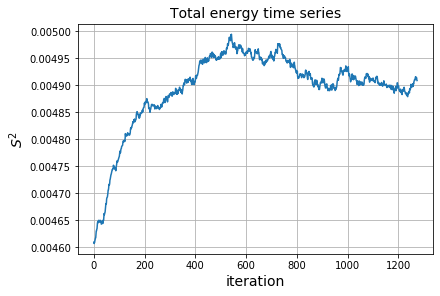

In [13]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(np.sum(energy, axis=1))
ax.set(xscale='linear', yscale='linear', xlabel='iteration', ylabel=r'$S^2$', title='Total energy time series'); ax.grid()
plt.show()

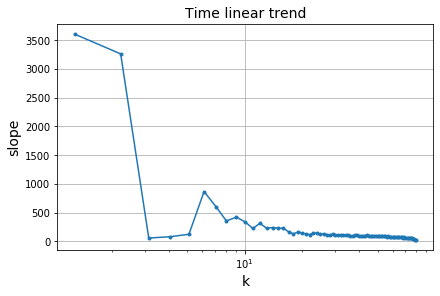

In [14]:
# linear trand by scales
lin_trend = np.zeros_like(k, dtype=float)
intercept = np.zeros_like(k, dtype=float)
for ik in list(range(len(k))): lin_trend[ik], intercept[ik], r_value, p_value, std_err = stats.linregress(time,energy[:,ik]/np.mean(energy[:,ik]))
    
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(k, lin_trend, '.-')
ax.set(xscale='log', yscale='linear', xlabel='k', ylabel='slope', title='Time linear trend'); ax.grid()
plt.show()

# PDF

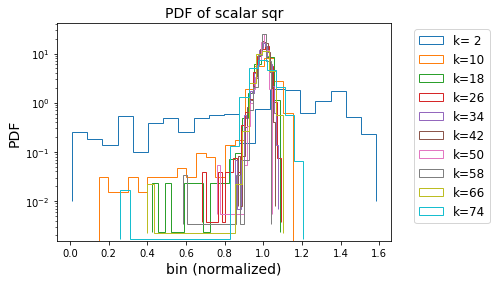

In [15]:
#plot histogram
nb_of_bins=20

for ik in indices_of_k_to_plot :
    plt.hist(x=energy[:,ik]*norm_coef[ik], bins=nb_of_bins, histtype='step', density=True, log=True, align='mid', label='k=%2.f' % (k[ik]/k_norm_coef))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PDF of scalar sqr')
plt.xlabel('bin (normalized)'); plt.ylabel("PDF")
plt.show()

# Mean energy vs. k (spectrum)

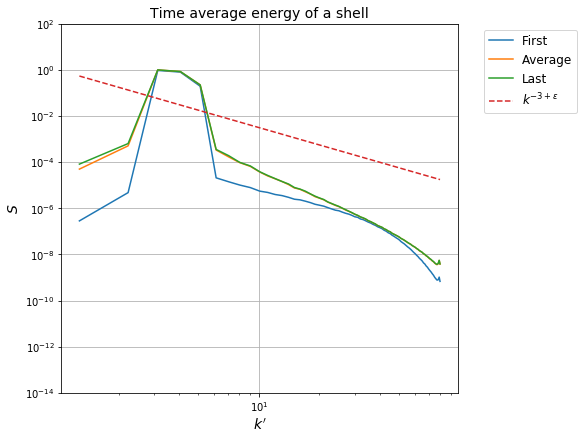

In [16]:
mean_energy = np.mean(energy, axis=0)
    
fig, ax = plt.subplots(constrained_layout=True, figsize=(8,6))
ax.plot(k, energy[0,:]/np.max(mean_energy), '-', label=r'First')
ax.plot(k, mean_energy/np.max(mean_energy), '-', label=r'Average')
ax.plot(k, energy[-1,:]/np.max(mean_energy), '-', label=r'Last')
ax.plot(k, k**(-3.0+eps),'--', label=r'$k^{-3 + \epsilon}$')
ax.set(xscale='log',yscale='log',xlabel=r'$k^\prime$', ylabel=r'$S$', title='Time average energy of a shell')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set(ylim=[10e-15,10e1])
ax.grid()
plt.show()

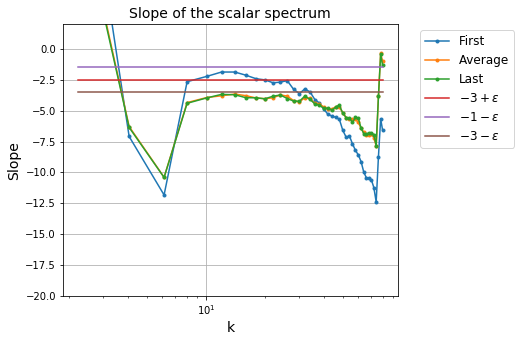

In [17]:
# check the slope of the mean energy
resampling = 2
x = np.log(k[1::resampling])
slope_avg = np.gradient(np.log(mean_energy[1::resampling]), x)
slope_first = np.gradient(np.log(energy[0,1::resampling]), x)
slope_last = np.gradient(np.log(energy[-1,1::resampling]), x)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
ax.plot(np.exp(x), slope_first, '.-', label='First')
ax.plot(np.exp(x), slope_avg, '.-', label='Average')
ax.plot(np.exp(x), slope_last, '.-', label='Last')
ax.plot(np.exp(x), np.full_like(x, (-3.0+eps), dtype=float), '-', label=r'$-3+\epsilon$')
ax.plot(np.exp(x), np.full_like(x, (-1.0-eps), dtype=float), '-', label=r'$-1-\epsilon$')
ax.plot(np.exp(x), np.full_like(x, (-3.0-eps), dtype=float), '-', label=r'$-3-\epsilon$')

ax.set(xscale='log', yscale='linear', title='Slope of the scalar spectrum', xlabel='k', ylabel='Slope'); ax.grid()
ax.set(ylim=[-20,2])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()